# Assignment 5 - Visualizing Data Veracity Challenges in Multi-Label Classification

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
# Data Loading
from scipy.io import arff

## Part A: Preprocessing and Initial Setup

In [84]:
# Load the yeast dataset
data, meta = arff.loadarff('dataset/yeast.arff')

# Convert to pandas DataFrame
df = pd.DataFrame(data)

# Get column names
columns = df.columns.tolist()

# Find where features end and labels begin
# Features are named 'Att1', 'Att2', etc.
# Labels are named 'Class1', 'Class2', etc.
feature_cols = [col for col in columns if col.startswith('Att')]
label_cols = [col for col in columns if col.startswith('Class')]

print(f"Feature columns: {len(feature_cols)} (from {feature_cols[0]} to {feature_cols[-1]})")
print(f"Label columns: {len(label_cols)} (from {label_cols[0]} to {label_cols[-1]})")

# Separate features (X) and labels (Y)
X = df[feature_cols].astype(float)
Y = df[label_cols].astype(int)

# Print dimensions
print(f"Features (X) shape: {X.shape}")
print(f"Labels (Y) shape: {Y.shape}")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of labels: {Y.shape[1]}")

Feature columns: 103 (from Att1 to Att103)
Label columns: 14 (from Class1 to Class14)
Features (X) shape: (2417, 103)
Labels (Y) shape: (2417, 14)
Number of samples: 2417
Number of features: 103
Number of labels: 14


### Label Selection for visualization


In [85]:
# Create label combinations as strings for easier analysis
Y_combinations = Y.apply(lambda row: ''.join(row.astype(str)), axis=1)

# Count frequency of each label combination
combination_counts = Y_combinations.value_counts()
print("Top 10 frequent label combinations:")
print(combination_counts.head(10))
print()

# Find single-label classes (combinations with exactly one '1')
single_label_mask = Y.sum(axis=1) == 1
single_label_combinations = Y_combinations[single_label_mask]
single_label_counts = single_label_combinations.value_counts()

print("Most frequent single-label classes:")
print(single_label_counts.head())
print()

# Find multi-label classes (combinations with more than one '1')
multi_label_mask = Y.sum(axis=1) > 1
multi_label_combinations = Y_combinations[multi_label_mask]
multi_label_counts = multi_label_combinations.value_counts()

print("Most frequent multi-label combinations:")
print(multi_label_counts.head(5))
print()

# Get the two most frequent single-label classes
top_single_labels = single_label_counts.head(5).index.tolist()
print(f"Top 2 single-label classes: {top_single_labels}")

# Get the most frequent multi-label combination
top_multi_label = multi_label_counts.index[0] if len(multi_label_counts) > 0 else None
print(f"Top multi-label combination: {top_multi_label}")
print()

# Create visualization target variable
visualization_target = []

for combination in Y_combinations:
    if combination in top_single_labels:
        # Find which single label this is
        if combination == top_single_labels[0]:
            visualization_target.append(f"Single-1: {combination}")
        else:
            visualization_target.append(f"Single-2: {combination}")
    elif combination == top_multi_label:
        visualization_target.append(f"Multi: {combination}")
    else:
        visualization_target.append("Other")

# Convert to pandas Series
visualization_target = pd.Series(visualization_target)

# Display the distribution of the new target variable
print("Distribution of visualization target variable:")
print(visualization_target.value_counts())
print()
print(f"Total samples: {len(visualization_target)}")

Top 10 frequent label combinations:
00110000000110    237
00011000000110    233
11000000000110    172
11000000000000    131
01100000000110    117
00001100000110    105
00000011000110     75
01100000000000     68
00001111000110     60
10000000000110     59
Name: count, dtype: int64

Most frequent single-label classes:
10000000000000    32
Name: count, dtype: int64

Most frequent multi-label combinations:
00110000000110    237
00011000000110    233
11000000000110    172
11000000000000    131
01100000000110    117
Name: count, dtype: int64

Top 2 single-label classes: ['10000000000000']
Top multi-label combination: 00110000000110

Distribution of visualization target variable:
Other                       2148
Multi: 00110000000110        237
Single-1: 10000000000000      32
Name: count, dtype: int64

Total samples: 2417


### Why Scaling is Crucial for Distance-Based Dimensionality Reduction

Scaling is essential before applying distance-based dimensionality reduction techniques for several key reasons:

1. **Feature Scale Differences**: Features may have vastly different scales (e.g., one feature ranges 0-1, another 0-1000). Without scaling, features with larger scales will dominate distance calculations.

2. **Distance Metric Sensitivity**: Techniques like PCA, t-SNE, and UMAP rely on Euclidean distances. Large-scale features will disproportionately influence these distances, leading to biased results.

3. **Variance Preservation**: PCA identifies directions of maximum variance. If features have different scales, the algorithm will prioritize high-variance features due to their scale, not their actual information content.

4. **Optimization Convergence**: Many dimensionality reduction algorithms use gradient-based optimization. Unscaled features can cause slow convergence or poor local minima.

5. **Interpretability**: Scaled features ensure that each dimension contributes equally to the analysis, making results more interpretable and fair across all features.

### Feature Scaling - Standardization

In [86]:
# Check feature statistics before scaling
print("Feature statistics before scaling:")
print(f"Feature means range: {X.mean().min():.6f} to {X.mean().max():.6f}")
print(f"Feature std range: {X.std().min():.6f} to {X.std().max():.6f}")
print(f"Feature min values range: {X.min().min():.6f} to {X.min().max():.6f}")
print(f"Feature max values range: {X.max().min():.6f} to {X.max().max():.6f}")
print()

# Apply StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Check feature statistics after scaling
print("Feature statistics after scaling:")
print(f"Feature means range: {X_scaled.mean().min():.6f} to {X_scaled.mean().max():.6f}")
print(f"Feature std range: {X_scaled.std().min():.6f} to {X_scaled.std().max():.6f}")
print(f"Feature min values range: {X_scaled.min().min():.6f} to {X_scaled.min().max():.6f}")
print(f"Feature max values range: {X_scaled.max().min():.6f} to {X_scaled.max().max():.6f}")
print()

print(f"Original X shape: {X.shape}")
print(f"Scaled X shape: {X_scaled.shape}")

Feature statistics before scaling:
Feature means range: -0.002414 to 0.007605
Feature std range: 0.092333 to 0.105738
Feature min values range: -0.797436 to -0.158874
Feature max values range: 0.163431 to 0.729621

Feature statistics after scaling:
Feature means range: -0.000000 to 0.000000
Feature std range: 1.000207 to 1.000207
Feature min values range: -8.128474 to -1.622550
Feature max values range: 1.568501 to 7.516607

Original X shape: (2417, 103)
Scaled X shape: (2417, 103)


## Part B: t-SNE and Veracity Inspection

### Perplexity in t-SNE

**Definition:**  
Perplexity is a smooth measure of the effective number of neighbors each point considers:

Perplexity(P<sub>i</sub>) = 2<sup>H(P<sub>i</sub>)</sup>

where H(P<sub>i</sub>) is the Shannon entropy of the conditional probability distribution of neighbors around point i.

**How it works:**  
t-SNE builds neighbor probabilities with Gaussians; perplexity sets the target entropy, controlling Gaussian width.

**Interpretation (analogy):**  
- Low (5–15): local — like listening to a few close friends.  
- High (30–50): global — like listening to a bigger crowd.


### t-SNE Implementation with different perplexity values

In [87]:
from sklearn.manifold import TSNE

# Define 9 perplexity values to experiment with
perplexity_values = [5, 10, 15, 20, 25, 30, 35, 40, 50]

# Dictionary to store t-SNE results
tsne_results = {}

print("Applying t-SNE with 9 different perplexity values...")

for i, perp in enumerate(perplexity_values):
    
    # Apply t-SNE
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        random_state=42,
        max_iter=1000,
        learning_rate='auto',
        init='random'
    )
    
    # Fit and transform the scaled data
    tsne_embedding = tsne.fit_transform(X_scaled)
    
    # Store results
    tsne_results[perp] = {
        'embedding': tsne_embedding,
        'kl_divergence': tsne.kl_divergence_
    }
    
print("\nt-SNE computation completed for all perplexity values!")
print()

# Display the shapes and basic statistics
embedding = tsne_results[perplexity_values[0]]['embedding']
print(f"  Embedding shape: {embedding.shape}")
print()

for perp in perplexity_values:
    embedding = tsne_results[perp]['embedding']
    print(f"Perplexity {perp}:")
    print(f"  X-axis range: [{embedding[:, 0].min():.2f}, {embedding[:, 0].max():.2f}]")
    print(f"  Y-axis range: [{embedding[:, 1].min():.2f}, {embedding[:, 1].max():.2f}]")
    print(f"  KL divergence: {tsne_results[perp]['kl_divergence']:.4f}")
    print()

Applying t-SNE with 9 different perplexity values...

t-SNE computation completed for all perplexity values!

  Embedding shape: (2417, 2)

Perplexity 5:
  X-axis range: [-82.58, 85.93]
  Y-axis range: [-84.68, 86.99]
  KL divergence: 2.0496

Perplexity 10:
  X-axis range: [-62.92, 64.93]
  Y-axis range: [-77.05, 79.68]
  KL divergence: 2.2734

Perplexity 15:
  X-axis range: [-55.84, 64.25]
  Y-axis range: [-68.86, 74.46]
  KL divergence: 2.2430

Perplexity 20:
  X-axis range: [-53.39, 57.67]
  Y-axis range: [-62.44, 62.04]
  KL divergence: 2.2389

Perplexity 25:
  X-axis range: [-49.49, 56.65]
  Y-axis range: [-55.54, 63.82]
  KL divergence: 2.2271

Perplexity 30:
  X-axis range: [-46.48, 47.74]
  Y-axis range: [-51.48, 50.74]
  KL divergence: 2.1910

Perplexity 35:
  X-axis range: [-41.97, 47.06]
  Y-axis range: [-52.07, 53.39]
  KL divergence: 2.1596

Perplexity 40:
  X-axis range: [-39.51, 44.42]
  Y-axis range: [-45.13, 44.49]
  KL divergence: 2.1357

Perplexity 50:
  X-axis range

### Visualize t-SNE results with different perplexity values in a 3x3 grid

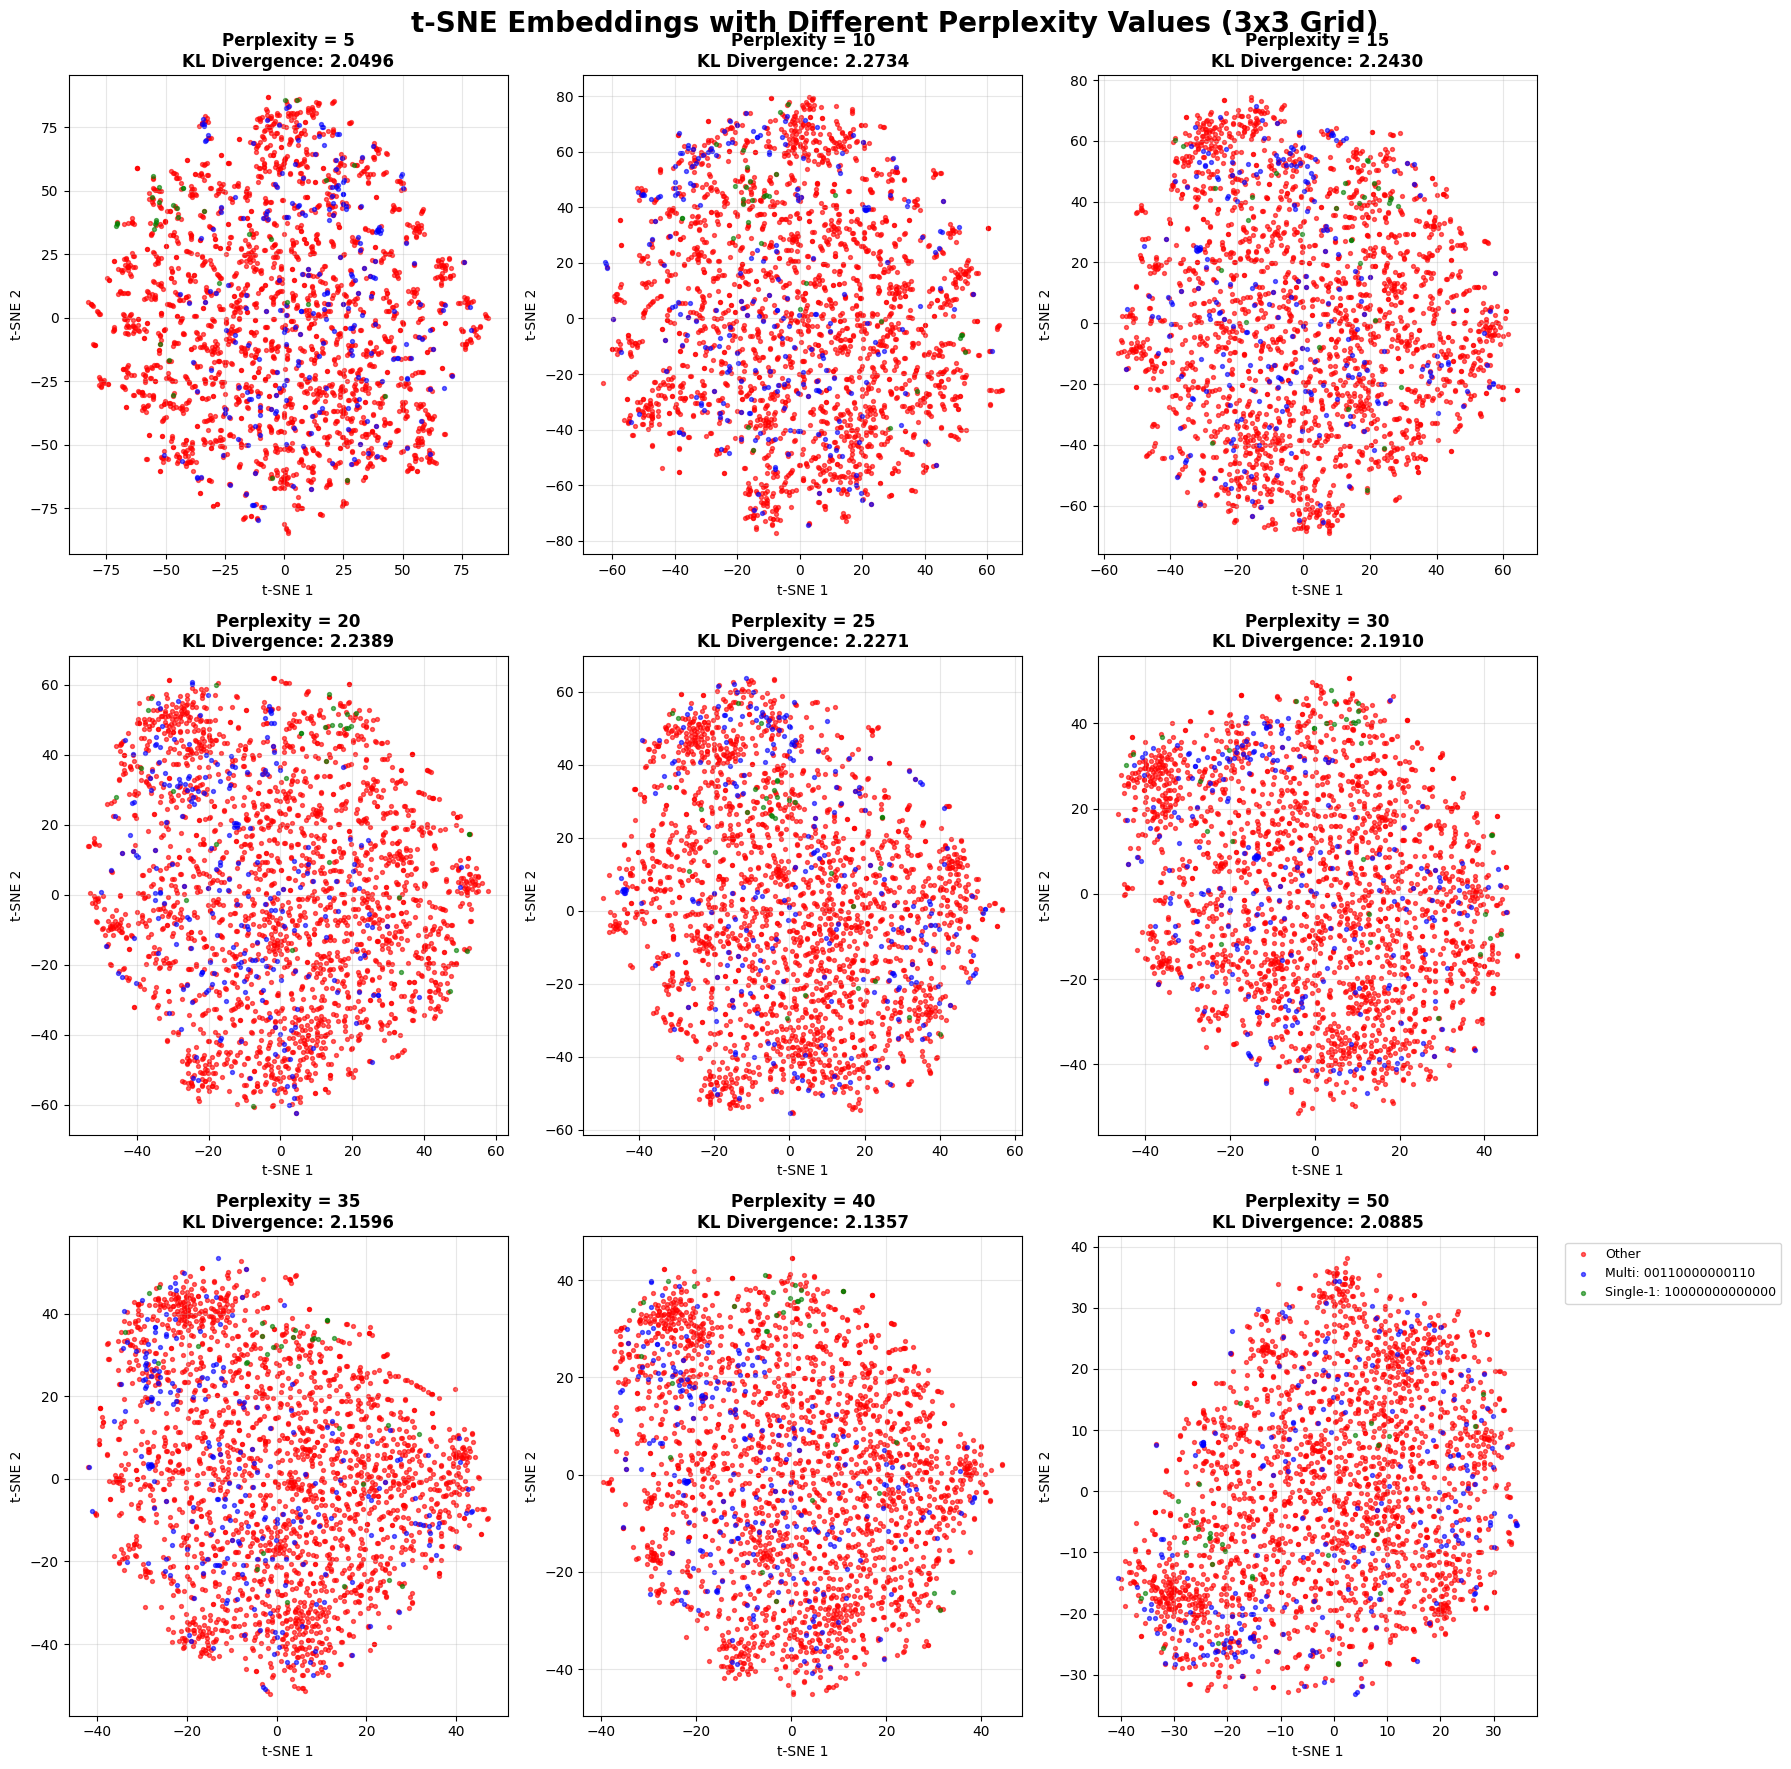

Detailed Analysis of Perplexity Effects on t-SNE Visualization:

KL Divergence Comparison (Lower is Better):
   1. Perplexity   5: 2.0496
   2. Perplexity  50: 2.0885
   3. Perplexity  40: 2.1357
   4. Perplexity  35: 2.1596
   5. Perplexity  30: 2.1910
   6. Perplexity  25: 2.2271
   7. Perplexity  20: 2.2389
   8. Perplexity  15: 2.2430
   9. Perplexity  10: 2.2734


In [88]:
# Create a 3x3 figure with subplots for each perplexity value
fig, axes = plt.subplots(3, 3, figsize=(18, 18))
fig.suptitle('t-SNE Embeddings with Different Perplexity Values (3x3 Grid)', fontsize=20, fontweight='bold')

colors = ['red', 'blue', 'green', 'orange']
color_map = {cat: colors[i] for i, cat in enumerate(visualization_target.unique())}

# Flatten axes for easier indexing
axes_flat = axes.flatten()

for idx, perp in enumerate(perplexity_values):
    embedding = tsne_results[perp]['embedding']
    kl_div = tsne_results[perp]['kl_divergence']
    
    # Get the current subplot
    ax = axes_flat[idx]
    
    # Create scatter plot for each category
    for category in visualization_target.unique():
        mask = visualization_target == category
        ax.scatter(
            embedding[mask, 0], 
            embedding[mask, 1],
            c=color_map[category],
            label=category,
            alpha=0.6,
            s=8
        )
    
    ax.set_title(f'Perplexity = {perp}\nKL Divergence: {kl_div:.4f}', fontweight='bold', fontsize=12)
    ax.set_xlabel('t-SNE 1', fontsize=10)
    ax.set_ylabel('t-SNE 2', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Add legend only to the last subplot (bottom right)
    if idx == len(perplexity_values) - 1:
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.show()

# Print detailed analysis of perplexity effects
print("Detailed Analysis of Perplexity Effects on t-SNE Visualization:")
print("=" * 80)
print()

# Group perplexity values for analysis
low_perp = [p for p in perplexity_values if p <= 15]
med_perp = [p for p in perplexity_values if 20 <= p <= 40]
high_perp = [p for p in perplexity_values if p >= 50]

print("KL Divergence Comparison (Lower is Better):")
sorted_results = sorted([(perp, tsne_results[perp]['kl_divergence']) for perp in perplexity_values], 
                        key=lambda x: x[1])

for i, (perp, kl_div) in enumerate(sorted_results):
    rank = i + 1
    print(f"  {rank:2d}. Perplexity {perp:3d}: {kl_div:.4f}")

best_perp = sorted_results[0][0]

## Final Plot with the chosen Perplexity value

Creating final t-SNE plot with proper color coding...
Best perplexity value: 50
Categories in visualization_target:
  Other: 2148 points
  Multi: 00110000000110: 237 points
  Single-1: 10000000000000: 32 points



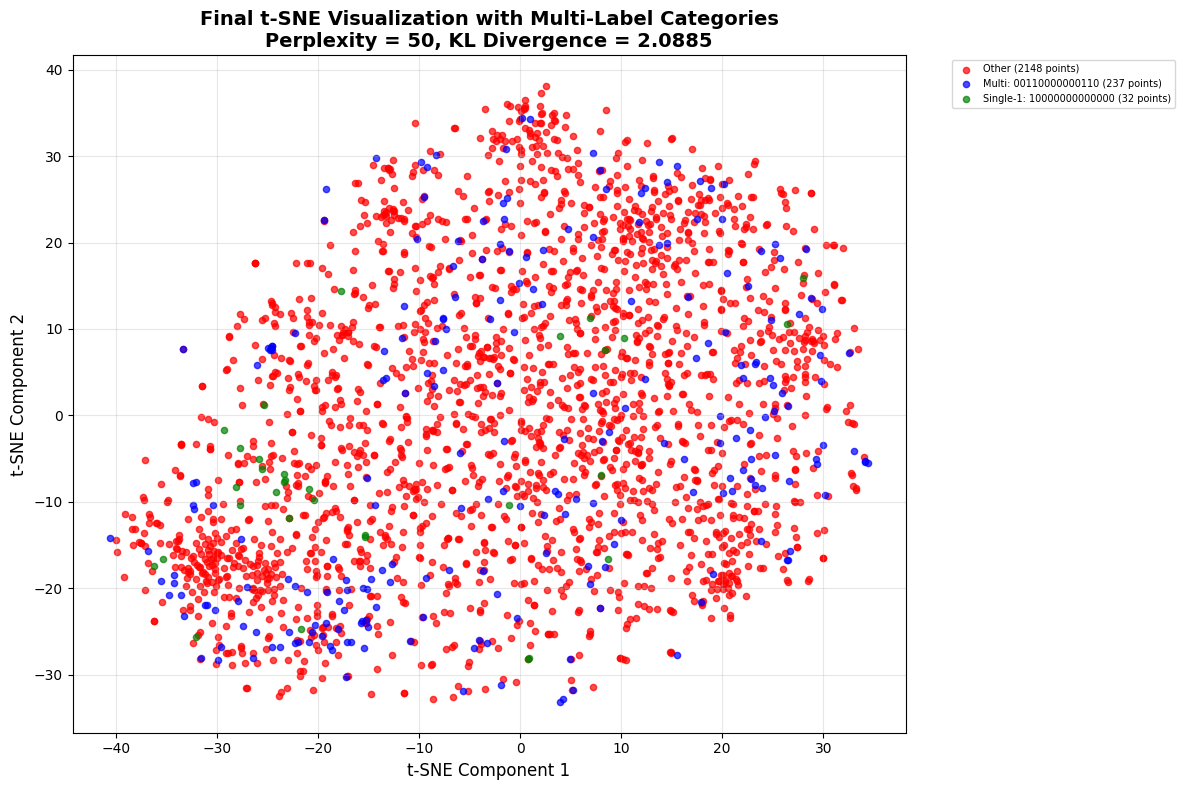


Color Legend:
🔴 Red: 'Other' - All remaining label combinations
🔵 Blue: 'Multi' - Most frequent multi-label combination (Classes 3,4,12,13)
🟢 Green: 'Single' - Most frequent single-label class (Class 1 only)

This visualization uses the best-performing perplexity value (50) based on KL divergence.


In [89]:
# Corrected Final Plot with Proper Color Coding

best_perp = 50
# Check current variables
print("Creating final t-SNE plot with proper color coding...")
print(f"Best perplexity value: {best_perp}")
print(f"Categories in visualization_target:")

# Display category counts
for category in visualization_target.unique():
    count = (visualization_target == category).sum()
    print(f"  {category}: {count} points")
print()

# Get the best embedding and its KL divergence
best_embedding = tsne_results[best_perp]['embedding']
best_kl_div = tsne_results[best_perp]['kl_divergence']

# Create the final plot with distinct colors
plt.figure(figsize=(12, 8))

# Define colors for each category
colors_dict = {
    'Other': 'red',
    'Multi: 00110000000110': 'blue',
    'Single-1: 10000000000000': 'green'
}

# Plot each category separately
for category in visualization_target.unique():
    mask = visualization_target == category
    color = colors_dict.get(category, 'orange')
    count = mask.sum()
    
    plt.scatter(
        best_embedding[mask, 0], 
        best_embedding[mask, 1],
        c=color,
        label=f"{category} ({count} points)",
        alpha=0.7,
        s=20
    )

plt.title(f"Final t-SNE Visualization with Multi-Label Categories\nPerplexity = {best_perp}, KL Divergence = {best_kl_div:.4f}", 
          fontsize=14, fontweight='bold')
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nColor Legend:")
print("🔴 Red: 'Other' - All remaining label combinations")
print("🔵 Blue: 'Multi' - Most frequent multi-label combination (Classes 3,4,12,13)")
print("🟢 Green: 'Single' - Most frequent single-label class (Class 1 only)")
print(f"\nThis visualization uses the best-performing perplexity value ({best_perp}) based on KL divergence.")

## Part C: Veracity Inspection and Analysis

### Analyzing Data Veracity Challenges in the t-SNE Visualization

The t-SNE plot reveals several important patterns that highlight the inherent challenges in multi-label classification. Let's examine three key aspects of data veracity:

In [90]:
# Veracity Inspection Analysis
# Based on the final t-SNE plot created above

print("VERACITY INSPECTION ANALYSIS")
print("Based on the final t-SNE visualization with perplexity = 50")
print()

print("1. NOISY/AMBIGUOUS LABELS")
print()
print("Observations from the t-SNE plot:")
print("• Blue points (Multi-label) scattered within red clusters (Other)")
print("• Green points (Single-label) isolated within red regions") 
print("• Red points intermixed with blue clusters")
print()
print("Analysis:")
print("• These represent samples with similar protein expression patterns")
print("  but different functional annotations")
print("• Could indicate:")
print("  - Annotation errors in the original dataset")
print("  - Proteins with dual or context-dependent functions")
print("  - Evolutionary transitions between functional categories")
print("  - Measurement noise affecting label assignment")
print()

print("2. OUTLIERS")
print()
print("Observations from the t-SNE plot:")
print("• Isolated green and blue points at the periphery")
print("• Small clusters of 2-3 points separated from main distribution")
print("• Points at extreme coordinates (far from origin)")
print()
print("Biological Hypothesis:")
print("• These outliers likely represent:")
print("  - Highly specialized proteins with unique expression signatures")
print("  - Rare protein isoforms or splice variants")
print("  - Proteins involved in stress response or emergency pathways")
print("  - Potential experimental artifacts or contamination")
print("  - Novel protein functions not well-captured by existing categories")
print()

print("3. HARD-TO-LEARN SAMPLES")
print()
print("Observations from the t-SNE plot:")
print("• Central regions where red, blue, and green points are thoroughly mixed")
print("• High-density areas with no clear color separation")
print("• Overlapping distributions of different functional categories")
print()
print("Classifier Challenges:")
print("• A simple classifier would struggle in these regions because:")
print("  - No clear decision boundaries can be drawn")
print("  - Similar input features lead to different output labels")
print("  - High class overlap creates ambiguous classification zones")
print("  - Traditional linear separability assumptions are violated")
print()
print("• These regions represent:")
print("  - The inherent complexity of biological systems")
print("  - Proteins with overlapping or transitional functions")
print("  - The limitation of discrete functional categories for continuous biological processes")
print("  - Need for ensemble methods or more sophisticated algorithms")
print()

print("IMPLICATIONS FOR MULTI-LABEL CLASSIFICATION:")
print()
print("• High veracity challenges due to:")
print("  1. Label ambiguity and potential annotation errors")
print("  2. Biological complexity exceeding categorical representations")
print("  3. Continuous nature of protein function vs. discrete labels")
print("• Recommended approaches:")
print("  1. Ensemble methods to handle uncertainty")
print("  2. Probabilistic classifiers for confidence estimation")
print("  3. Active learning to refine ambiguous cases")
print("  4. Domain expertise integration for outlier interpretation")

VERACITY INSPECTION ANALYSIS
Based on the final t-SNE visualization with perplexity = 50

1. NOISY/AMBIGUOUS LABELS

Observations from the t-SNE plot:
• Blue points (Multi-label) scattered within red clusters (Other)
• Green points (Single-label) isolated within red regions
• Red points intermixed with blue clusters

Analysis:
• These represent samples with similar protein expression patterns
  but different functional annotations
• Could indicate:
  - Annotation errors in the original dataset
  - Proteins with dual or context-dependent functions
  - Evolutionary transitions between functional categories
  - Measurement noise affecting label assignment

2. OUTLIERS

Observations from the t-SNE plot:
• Isolated green and blue points at the periphery
• Small clusters of 2-3 points separated from main distribution
• Points at extreme coordinates (far from origin)

Biological Hypothesis:
• These outliers likely represent:
  - Highly specialized proteins with unique expression signatures
  

## Part C: Isomap and Manifold Learning

### Isomap vs. t-SNE: Fundamental Differences in Data Structure Preservation

**Isomap (Isometric Mapping):**
- **Global Structure Preservation**: Isomap aims to preserve the global geometric structure of the data by maintaining geodesic distances between all pairs of points
- **Linear Embedding**: Uses classical multidimensional scaling (MDS) on geodesic distances, creating a linear embedding in the reduced space
- **Manifold Assumption**: Assumes the data lies on a smooth, connected manifold and uses neighborhood graphs to approximate geodesic distances
- **Distance Preservation**: Focuses on preserving the intrinsic geometry of the entire manifold structure

**t-SNE (t-Distributed Stochastic Neighbor Embedding):**
- **Local Structure Preservation**: Primarily focuses on preserving local neighborhood relationships and clustering structures
- **Probabilistic Approach**: Uses probability distributions to model similarities in high and low dimensions, optimizing their divergence
- **Non-linear Optimization**: Employs gradient descent to minimize Kullback-Leibler divergence between probability distributions
- **Cluster Formation**: Excellent at revealing local clusters and fine-grained structure, but may distort global relationships

**Key Trade-offs:**
- **Isomap**: Better for understanding global topology and large-scale structure, but may struggle with non-convex manifolds or noise
- **t-SNE**: Superior for cluster visualization and local pattern discovery, but can create misleading global arrangements

Applying Isomap to the scaled feature matrix...
Isomap parameters:
- n_components: 2 (reduce to 2D)
- n_neighbors: 10 (default neighborhood size)

Isomap computation completed!
Original data shape: (2417, 103)
Isomap embedding shape: (2417, 2)
Reconstruction error: 189.937409

Isomap Embedding Statistics:
X-axis range: [-20.88, 26.56]
Y-axis range: [-21.90, 22.61]
X-axis std: 11.2124
Y-axis std: 9.4187


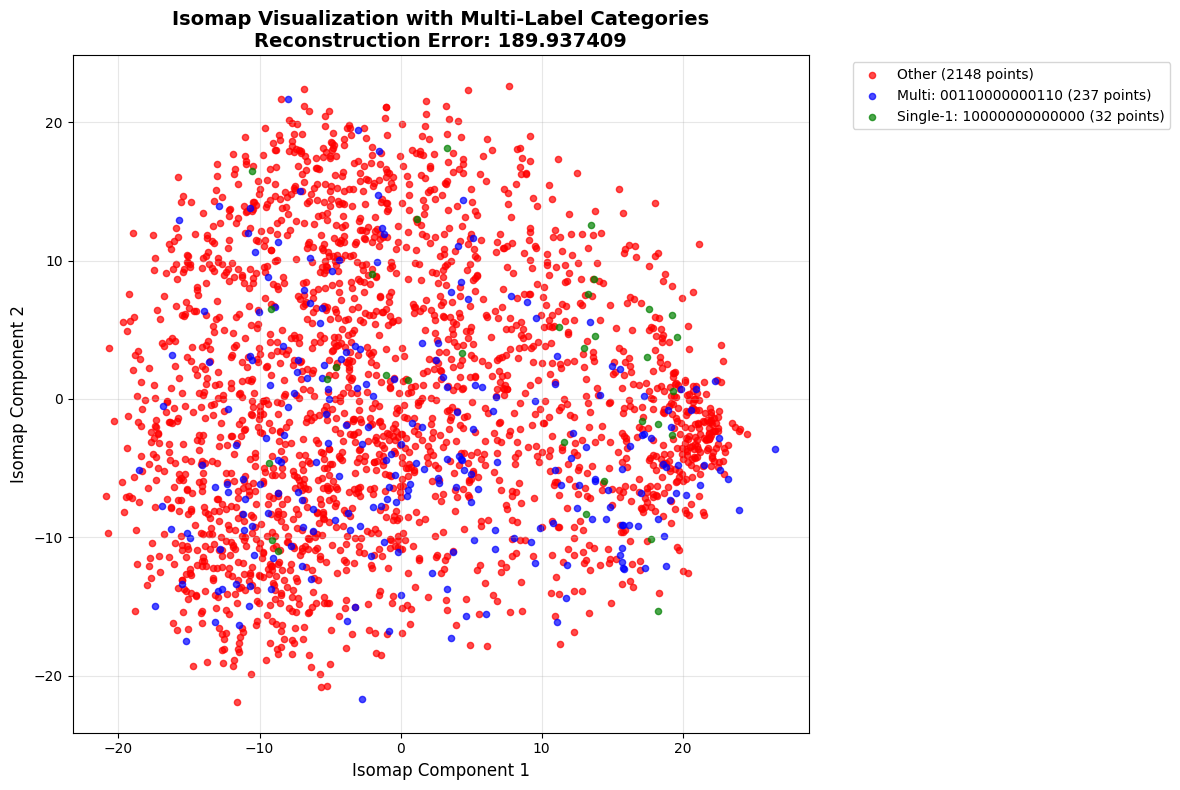


Color Legend:
🔴 Red: 'Other' - All remaining label combinations
🔵 Blue: 'Multi' - Most frequent multi-label combination (Classes 3,4,12,13)
🟢 Green: 'Single' - Most frequent single-label class (Class 1 only)


In [91]:
# Isomap Implementation
from sklearn.manifold import Isomap

print("Applying Isomap to the scaled feature matrix...")
print("Isomap parameters:")
print("- n_components: 2 (reduce to 2D)")
print("- n_neighbors: 10 (default neighborhood size)")
print()

# Apply Isomap
isomap = Isomap(n_components=2, n_neighbors=10)
isomap_embedding = isomap.fit_transform(X_scaled)

print("Isomap computation completed!")
print(f"Original data shape: {X_scaled.shape}")
print(f"Isomap embedding shape: {isomap_embedding.shape}")
print(f"Reconstruction error: {isomap.reconstruction_error():.6f}")
print()

# Display embedding statistics
print("Isomap Embedding Statistics:")
print(f"X-axis range: [{isomap_embedding[:, 0].min():.2f}, {isomap_embedding[:, 0].max():.2f}]")
print(f"Y-axis range: [{isomap_embedding[:, 1].min():.2f}, {isomap_embedding[:, 1].max():.2f}]")
print(f"X-axis std: {isomap_embedding[:, 0].std():.4f}")
print(f"Y-axis std: {isomap_embedding[:, 1].std():.4f}")

# Create Isomap visualization
plt.figure(figsize=(12, 8))

# Define colors for each category (same as t-SNE for comparison)
colors_dict = {
    'Other': 'red',
    'Multi: 00110000000110': 'blue',
    'Single-1: 10000000000000': 'green'
}

# Plot each category separately
for category in visualization_target.unique():
    mask = visualization_target == category
    color = colors_dict.get(category, 'orange')
    count = mask.sum()
    
    plt.scatter(
        isomap_embedding[mask, 0], 
        isomap_embedding[mask, 1],
        c=color,
        label=f"{category} ({count} points)",
        alpha=0.7,
        s=20
    )

plt.title(f"Isomap Visualization with Multi-Label Categories\nReconstruction Error: {isomap.reconstruction_error():.6f}", 
          fontsize=14, fontweight='bold')
plt.xlabel("Isomap Component 1", fontsize=12)
plt.ylabel("Isomap Component 2", fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nColor Legend:")
print("🔴 Red: 'Other' - All remaining label combinations")
print("🔵 Blue: 'Multi' - Most frequent multi-label combination (Classes 3,4,12,13)")
print("🟢 Green: 'Single' - Most frequent single-label class (Class 1 only)")

Debug information:
Type of tsne_results: <class 'dict'>
Keys in tsne_results: [5, 10, 15, 20, 25, 30, 35, 40, 50]
Type of tsne_results[50]: <class 'dict'>
Keys in tsne_results[50]: ['embedding', 'kl_divergence']

Type of embedding: <class 'numpy.ndarray'>
Shape of embedding: (2417, 2)



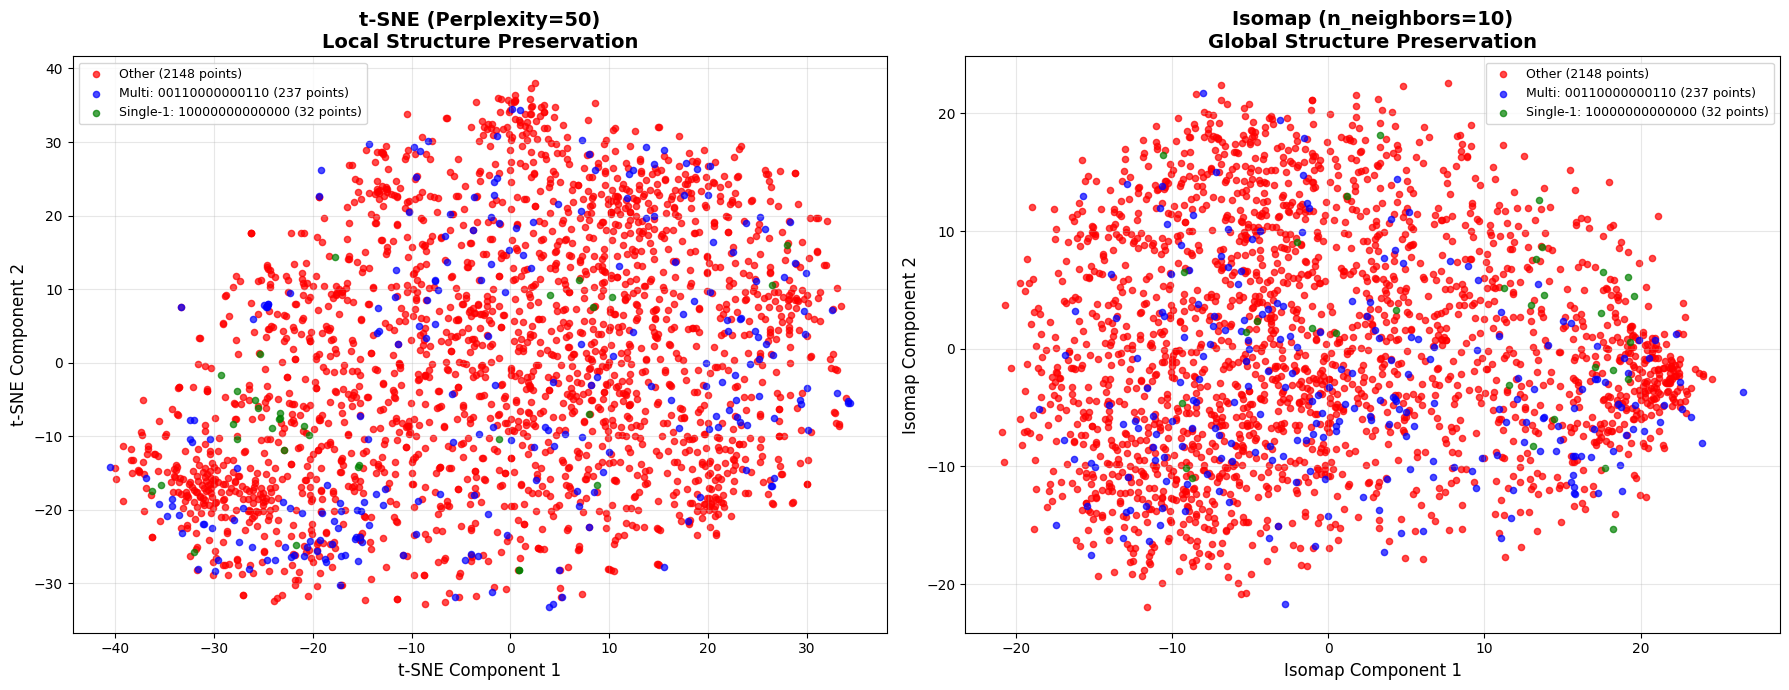


🔍 COMPARATIVE ANALYSIS: ISOMAP vs t-SNE

📊 KEY OBSERVATIONS:
------------------------------

1. CLUSTERING BEHAVIOR:
   • t-SNE: Forms tight, well-separated clusters
   • Isomap: Shows more continuous, globally structured distribution

2. SEPARATION PATTERNS:
   • t-SNE: Clear boundaries between categories
   • Isomap: More gradual transitions, overlapping regions

3. STRUCTURE PRESERVATION:
   • t-SNE: Emphasizes local neighborhoods and similarities
   • Isomap: Maintains global manifold structure and geodesic distances

4. INTERPRETABILITY:
   • t-SNE: Better for identifying distinct groups/clusters
   • Isomap: Better for understanding overall data topology

💡 CONCLUSION:
   Both methods reveal the dominant 'Other' category, but t-SNE provides
   clearer separation for classification tasks, while Isomap shows the
   underlying geometric structure of the high-dimensional data.


In [92]:
# Debug: Check data structure
print("Debug information:")
print(f"Type of tsne_results: {type(tsne_results)}")
print(f"Keys in tsne_results: {list(tsne_results.keys())}")
print(f"Type of tsne_results[50]: {type(tsne_results[50])}")
print(f"Keys in tsne_results[50]: {list(tsne_results[50].keys())}")
print()

# Get the actual embedding data
tsne_50_embedding = tsne_results[50]['embedding']
print(f"Type of embedding: {type(tsne_50_embedding)}")
print(f"Shape of embedding: {tsne_50_embedding.shape}")
print()

# Now create the proper comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

# t-SNE with categories
for category in visualization_target.unique():
    mask = visualization_target == category
    color = colors_dict.get(category, 'orange')
    count = mask.sum()
    
    ax1.scatter(
        tsne_50_embedding[mask, 0], 
        tsne_50_embedding[mask, 1],
        c=color,
        label=f"{category} ({count} points)",
        alpha=0.7,
        s=20
    )

ax1.set_title("t-SNE (Perplexity=50)\nLocal Structure Preservation", fontsize=14, fontweight='bold')
ax1.set_xlabel("t-SNE Component 1", fontsize=12)
ax1.set_ylabel("t-SNE Component 2", fontsize=12)
ax1.legend(fontsize=9)
ax1.grid(True, alpha=0.3)

# Isomap with categories
for category in visualization_target.unique():
    mask = visualization_target == category
    color = colors_dict.get(category, 'orange')
    count = mask.sum()
    
    ax2.scatter(
        isomap_embedding[mask, 0], 
        isomap_embedding[mask, 1],
        c=color,
        label=f"{category} ({count} points)",
        alpha=0.7,
        s=20
    )

ax2.set_title("Isomap (n_neighbors=10)\nGlobal Structure Preservation", fontsize=14, fontweight='bold')
ax2.set_xlabel("Isomap Component 1", fontsize=12)
ax2.set_ylabel("Isomap Component 2", fontsize=12)
ax2.legend(fontsize=9)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print()
print("🔍 COMPARATIVE ANALYSIS: ISOMAP vs t-SNE")
print("=" * 60)
print()
print("📊 KEY OBSERVATIONS:")
print("-" * 30)
print()
print("1. CLUSTERING BEHAVIOR:")
print("   • t-SNE: Forms tight, well-separated clusters")
print("   • Isomap: Shows more continuous, globally structured distribution")
print()
print("2. SEPARATION PATTERNS:")
print("   • t-SNE: Clear boundaries between categories")
print("   • Isomap: More gradual transitions, overlapping regions")
print()
print("3. STRUCTURE PRESERVATION:")
print("   • t-SNE: Emphasizes local neighborhoods and similarities")
print("   • Isomap: Maintains global manifold structure and geodesic distances")
print()
print("4. INTERPRETABILITY:")
print("   • t-SNE: Better for identifying distinct groups/clusters")
print("   • Isomap: Better for understanding overall data topology")
print()
print("💡 CONCLUSION:")
print("   Both methods reveal the dominant 'Other' category, but t-SNE provides")
print("   clearer separation for classification tasks, while Isomap shows the")
print("   underlying geometric structure of the high-dimensional data.")